<a href="https://colab.research.google.com/github/jo1jun/Image-Captioning-with-Transformer/blob/main/Transformer_Captioning_CS231N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, device & dtype


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

# tensor 연산을 간편하게 하기 위해 einops moudule import.
# reference & tutorial : http://einops.rocks/pytorch-examples.html
%pip install einops
from einops import rearrange, repeat

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


# COCO dataset (CS231N)

In [7]:
# This downloads the COCO dataset to your Drive
%cd ./dataset/COCO/cs231n/datasets/
!wget "http://cs231n.stanford.edu/coco_captioning.zip"
!unzip coco_captioning.zip
!rm coco_captioning.zip

[Errno 2] No such file or directory: './dataset/COCO/cs231n/datasets/'
/content/drive/MyDrive/dataset/COCO/cs231n/datasets
--2021-05-29 05:26:45--  http://cs231n.stanford.edu/coco_captioning.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1035210391 (987M) [application/zip]
Saving to: ‘coco_captioning.zip’

coco_captioning.zip 100%[===================>] 987.25M  12.9MB/s    in 68s     

2021-05-29 05:27:53 (14.5 MB/s) - ‘coco_captioning.zip’ saved [1035210391/1035210391]

Archive:  coco_captioning.zip
replace coco_captioning/coco2014_captions.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
# Setup cell.
import sys
sys.path.append('..')
import time, json
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/MyDrive/dataset/COCO/cs231n/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# COCO sample (CS231N)

base dir  /content/drive/MyDrive/dataset/COCO/cs231n/datasets/coco_captioning
dict_keys(['train_captions', 'train_image_idxs', 'val_captions', 'val_image_idxs', 'train_features', 'val_features', 'idx_to_word', 'word_to_idx', 'train_urls', 'val_urls'])
[[  1   4 142 ...   0   0   0]
 [  1   4   3 ...   0   0   0]
 [  1   4  60 ...   0   0   0]
 ...
 [  1   4 249 ...   0   0   0]
 [  1  16 186 ...   0   0   0]
 [  1   4 571 ...   0   0   0]]


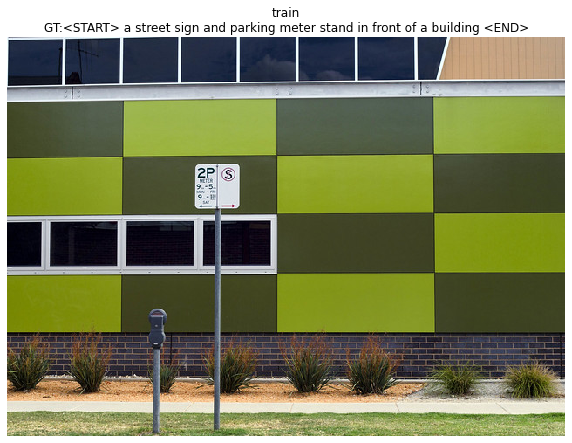

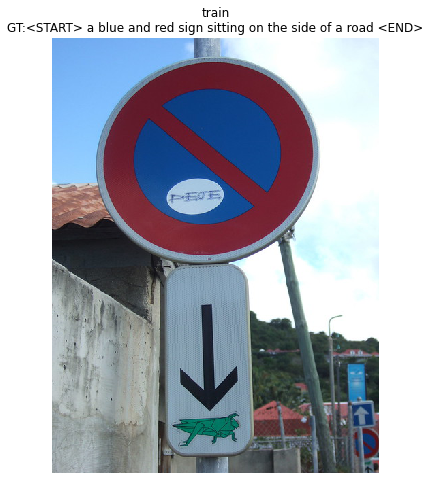

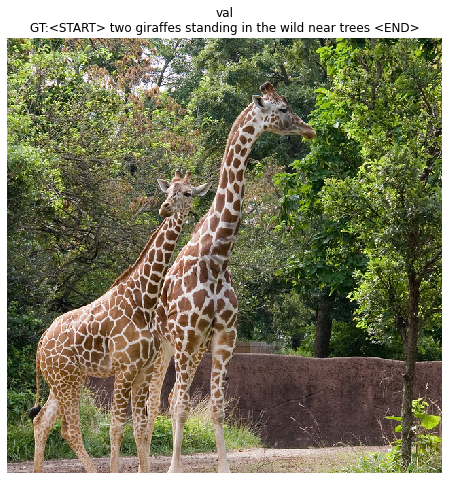

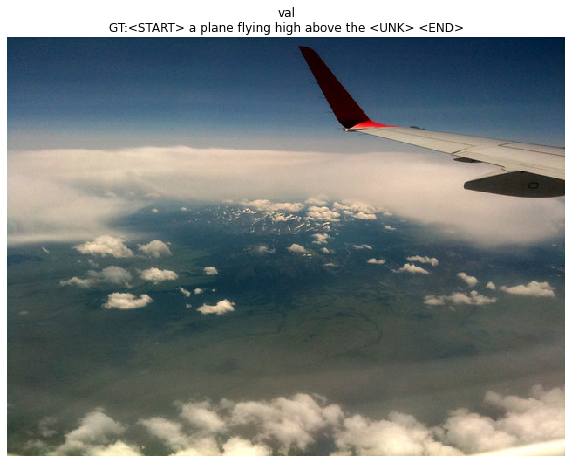

In [11]:
data = load_coco_data()
print(data.keys())
print(data['train_captions']) # <NULL> : 0, <START> : 1, <END> : 2, <UNK> : 3

for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    for gt_caption, url in zip(gt_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\nGT:%s' % (split, gt_caption))
        plt.axis('off')
        plt.show()

# Token & Positional Embedding

In [12]:
class TokPosEmbedding(nn.Module):
  def __init__(self, input_dim, d_model, dropout_ratio):
    super().__init__()
    # input_dim : input 의 vocab 수.
    self.tokEmbedding = nn.Embedding(input_dim, d_model)
    self.posEmbedding = nn.Embedding(100, d_model) # cos & sin positional encoding 대신, learnable positional embedding 으로 구현. (max length = 100)
                                                   # max length : 입력 sequence 의 최대 길이.
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, src):
    batch_size = src.shape[0]
    src_len = src.shape[1]

    # 0 ~ src_len 등차 수열값 을 bactch 한개와 동일한 shape으로 생성 (positional embedding)
    pos = torch.arange(0, src_len, dtype=dtype) # pos: [src_len]
    pos = repeat(pos, 'l -> b l', b=batch_size).to(device) # pos: [batch_size, src_len]

    src = self.dropout((self.tokEmbedding(src) * np.sqrt(self.d_model)) + self.posEmbedding(pos))

    # src: [batch_size, src_len, d_model]

    return src

# Transformer

In [22]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.project = nn.Linear(input_dim, d_model)

        self.decEmbedding = TokPosEmbedding(output_dim, d_model, dropout_ratio)               # 외부에서 embedding
        self.decoderLayer = nn.TransformerDecoderLayer(d_model, nhead, ff_dim, dropout_ratio) # 구현되어있는 module 사용
        self.decoder = nn.TransformerDecoder(self.decoderLayer, n_layers)                     # 구현되어있는 module 사용
        self.linear = nn.Linear(d_model, output_dim)                                          # 외부에서 마지막 fc-layer

    def make_pad_mask(self, src, pad):

        # src: [batch_size, src_len]

        # pad mask
        src_mask = (src.data.eq(pad))

        # src_mask: [batch_size, src_len]
        return src_mask

    def forward(self, src, tgt, pad):

        # src : 이미지 소스 : [batch_size, 512]
        
        # 이미지 소스를 인코더의 출력으로 대체한다.
        # 디코더에 맞게 VGG 를 통과한 representation 을 FC layer 로 차원 축소하여 decoder의 중간 layer 들에 넣어준다. 

        src = self.project(src)

        src = src.unsqueeze(1)  

        # tgt: [batch_size, tgt_len]

        tgt_pad_mask = self.make_pad_mask(tgt, pad)
        # chitting 방지 mask 의 경우, 아래와 같이 이미 구현되어있다. 기존과 mask 값이 다르므로 이미 구현된 것을 사용하면 된다.
        tgt_sub_mask = nn.Transformer.generate_square_subsequent_mask(self, sz=tgt.shape[1]).to(device)

        # tgt_pad_mask: [batch_size, tgt_len]
        # tgt_sub_mask: [tgt_len, tgt_len]

        tgt = self.decEmbedding(tgt)

        output = self.decoder(tgt.transpose(0,1).float(), src.float(), tgt_sub_mask, None, tgt_pad_mask, None)

        # output: [tgt_len, batch_size, d_model]

        output = self.linear(output.transpose(0, 1))

        # output: [batch_size, tgt_len, output_dim]

        return output

    def generate(self, src, start_id, sample_size, pad):

        # src : 이미지 소스 : [batch_size, 512]
        batch_size = src.shape[0]

        src = self.project(src)

        src = src.unsqueeze(1)  
      
        sampled_tensor = start_id
        # sampled_tensor: [1]

        sampled_tensor = repeat(sampled_tensor, 's -> b s', b=batch_size).to(device)
        # sampled_tensor: [batch_size, 1]
        for _ in range(sample_size):

          tgt_pad_mask = self.make_pad_mask(sampled_tensor, pad)
          tgt = self.decEmbedding(sampled_tensor)
          
          # generate 할 때는 하나씩 단어를 생성하므로 tgt_sub_mask 의미 x
          output = self.decoder(tgt.transpose(0,1), src, None, None, tgt_pad_mask, None)
          output = self.linear(output.transpose(0,1))

          pred_token = output.argmax(2)[:,-1].unsqueeze(1)

          sampled_tensor = torch.cat((sampled_tensor, pred_token), 1) # pred sentence 에 concat

        return sampled_tensor

# Hyperparameters (overfitting)

In [23]:
batch_size = 25
num_epochs = 100
vocab_size = 1004
feature_dim = 512
d_model = 256
n_layers = 2
nhead = 2
ff_dim = 2048
dropout_ratio = 0.1
learning_rate = 0.001

pad = 0
start = 1
max_len = 17

In [24]:
model = Transformer(feature_dim, vocab_size, d_model, n_layers, nhead, ff_dim, dropout_ratio) 
optimizer = optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

In [25]:
data = load_coco_data(max_train=100)

base dir  /content/drive/MyDrive/dataset/COCO/cs231n/datasets/coco_captioning


# Trainer

In [26]:
def trainer(model, criterion, optimizer, num_epochs, pad):

    pad = torch.tensor([pad], dtype=dtype).to(device)

    model = model.to(device)
    running_loss = {}

    num_train = data['train_captions'].shape[0]
    iterations_per_epoch = max(num_train // batch_size, 1)

    for e in range(num_epochs):

        print('Epoch {}/{}'.format(e, num_epochs))
        print('-' * 10)

        for phase in ['train']:
          if phase == 'train':
            model.train()  # Set model to training mode
          else:
            model.eval()   # Set model to evaluate mode

          running_loss[phase] = 0.0

          for iter in range(iterations_per_epoch):

              captions, features, _ = sample_coco_minibatch(data, batch_size=batch_size, split=phase)

              features = torch.tensor(features).to(device).float()
              captions = torch.tensor(captions).to(device).long()

              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                scores = model(features, captions[:, :-1], pad) # correct 값의 마지막 원소 배제 (end token 없음. 마지막 원소 다음 token 학습할 필요 x)
                # scores: [batch_size, tgt_len - 1, output_dim]
                scores = rearrange(scores, 'b l d -> (b l) d')
                # captions: [batch_size, tgt_len]
              
                # correct 값의 첫 원소 배제
                captions = rearrange(captions[:, 1:], 'b l -> (b l)')

                # scores  : [batch_size * tgt_len - 1, output_dim]
                # captions : [batch_size * tgt_len - 1]

                loss = criterion(scores, captions)

                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer.step()

              running_loss[phase] += loss.item() * batch_size

          running_loss[phase] = running_loss[phase] / (iterations_per_epoch * batch_size)

          print('{} Loss: {:.4f}'.format(phase, running_loss[phase]))

    return model

In [27]:
model = trainer(model, criterion, optimizer, num_epochs, pad)

Epoch 0/100
----------
train Loss: 5.2652
Epoch 1/100
----------
train Loss: 3.6820
Epoch 2/100
----------
train Loss: 3.0841
Epoch 3/100
----------
train Loss: 2.9894
Epoch 4/100
----------
train Loss: 2.6559
Epoch 5/100
----------
train Loss: 2.4543
Epoch 6/100
----------
train Loss: 2.2454
Epoch 7/100
----------
train Loss: 2.0179
Epoch 8/100
----------
train Loss: 1.8878
Epoch 9/100
----------
train Loss: 1.6144
Epoch 10/100
----------
train Loss: 1.4402
Epoch 11/100
----------
train Loss: 1.3542
Epoch 12/100
----------
train Loss: 1.1629
Epoch 13/100
----------
train Loss: 1.0072
Epoch 14/100
----------
train Loss: 0.9150
Epoch 15/100
----------
train Loss: 0.8077
Epoch 16/100
----------
train Loss: 0.6983
Epoch 17/100
----------
train Loss: 0.6307
Epoch 18/100
----------
train Loss: 0.4907
Epoch 19/100
----------
train Loss: 0.4643
Epoch 20/100
----------
train Loss: 0.3894
Epoch 21/100
----------
train Loss: 0.3579
Epoch 22/100
----------
train Loss: 0.3144
Epoch 23/100
--------

# Caption Generating

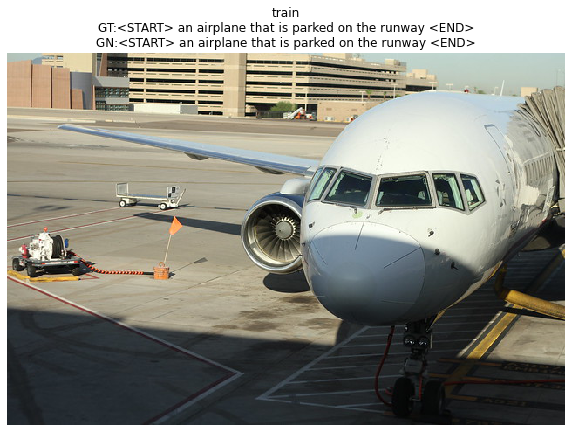

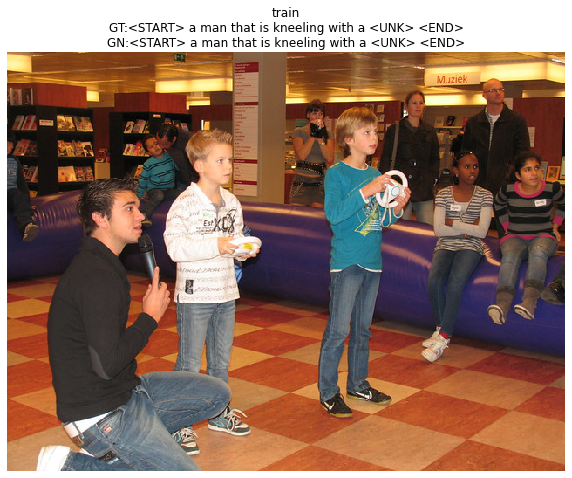

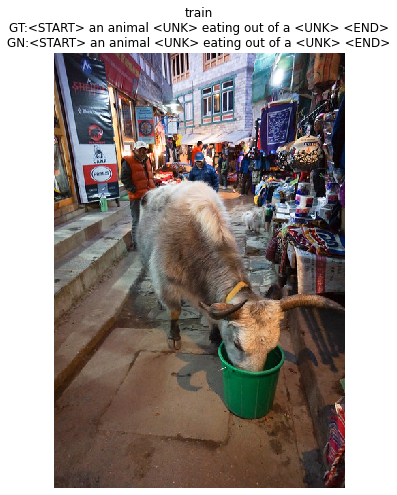

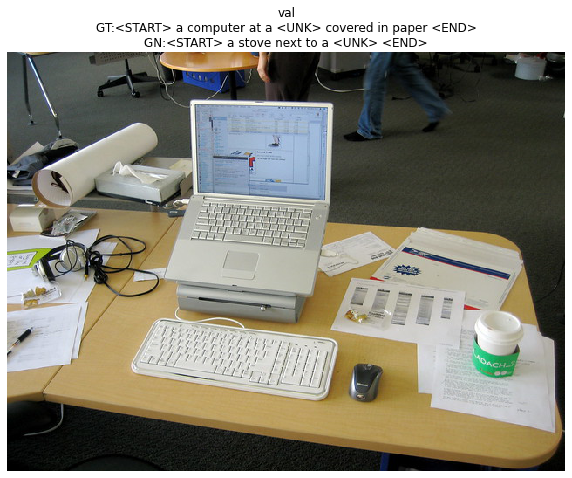

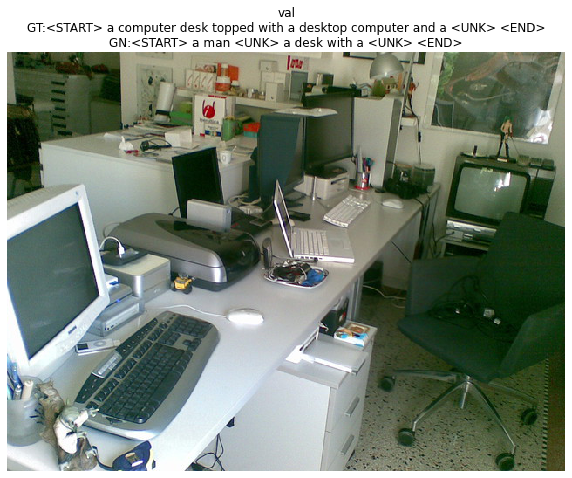

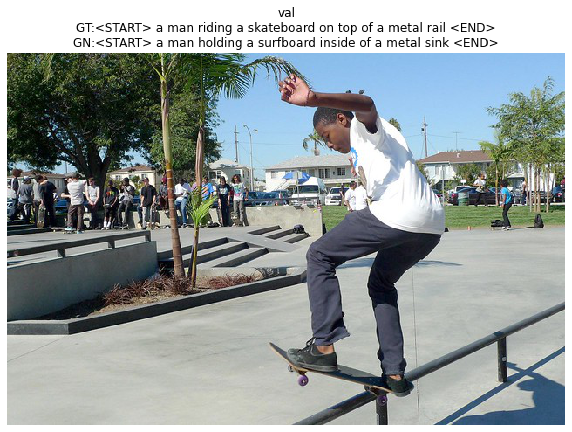

In [36]:
# 학습 데이터가 매우 적어, 일반화가 매우 떨어진다.

for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=3)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    features = torch.FloatTensor(features).to(device)
    start = torch.tensor([start], dtype=dtype).to(device)
    pad = torch.tensor([pad], dtype=dtype).to(device)

    gn_captions = model.generate(features, start, max_len, pad)
    gn_captions = decode_captions(gn_captions, idx_to_word=data['idx_to_word'])

    for gt_caption, gn_caption, url in zip(gt_captions, gn_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\nGT:%s\nGN:%s' % (split, gt_caption, gn_caption)) # GT : ground truth / GN : generated caption
        plt.axis('off')
        plt.show()